# Runtime and Memory Profiling of Proximity-Based Clustering

## Benchmarking Setup

To simplify the benchmarking, we fix the number of clusters to **k = 4**. We evaluate the performance of distance matrix computation and clustering across varying sample sizes, measuring both **runtime** and **memory usage**.

The benchmarking is performed by running the script `profiling.py` with the following parameters:

* `k=4` (number of clusters)
* `n=10` (number of iterations for averaging runtime and memory consumption)

All benchmarks are conducted on a **MacBook Air with an Apple M3 chip** and **24 GB of RAM**.

In [ ]:
from profiling import (
    plot_benchmark_distance_matrix, 
    plot_benchmark_cluster_methods, 
    plot_benchmark_cluster_approaches
)

## Distance Matrix Computation in Forest-Guided Clustering

In **Forest-Guided Clustering (FGC)**, the core idea is to use proximity information derived from a trained Random Forest to perform clustering. Specifically, we compute a **distance matrix** based on the pairwise proximity between samples in the forest. This distance matrix is then used as input for **k-medoids clustering**, which allows interpretable partitioning of the data.

Given that the k-medoids algorithm operates on a full pairwise distance matrix, computing and storing this matrix efficiently becomes crucial—especially for large datasets. The runtime and memory requirements scale quadratically with the number of samples (**O(n²)**), which can quickly become a bottleneck. Hence, we need to improve the performance and memory efficiency of distance matrix computation in this context.

To enable clustering on large datasets, we must reduce theruntime and memory footprint of the distance matrix. Since the matrix grows quadratically with sample size, memory usage becomes a critical constraint. To address both, runtime and memory bottlenecks, we explore the following strategies:

1. **Memory Mapping with `memmap`**:
   Instead of holding the entire matrix in RAM, we use NumPy’s `memmap` to memory-map large arrays to disk. This allows processing of datasets larger than available RAM by loading only required chunks into memory.

2. **Efficient Computation with `numba`**:
   `numba`-accelerated functions help speed up the generation of the distance matrix, making it feasible to compute even when using slower disk-backed memory. **`numba`** brings significant performance benefits through:
    - **Just-In-Time (JIT) Compilation** – Converts Python functions into optimized machine code, achieving near C/Fortran performance.
    - **Type Inference** – Enforces static types (e.g., `float64` arrays, `int32` scalars), allowing fast execution of numeric operations.
    - **Parallelization** – Automatically parallelizes loops for multi-core performance gains.

3. **Sparse Matrix Formats (Rejected)**:
   Although formats like `csr_matrix` (from SciPy) can save memory for sparse data, distance matrices are often dense. Moreover, sparse formats require storing three separate arrays (indices, values, indptr), potentially increasing memory usage. Additionally, the `kmedoids` package does not support sparse input directly, so we do not pursue this approach further.

To further reduce memory use and improve performance:

* We only compute and store the **upper triangle** of the distance matrix, leveraging symmetry to infer the lower triangle later.
* The matrix is initialized with zeros (`0.0`), so we skip diagonal elements (which are always zero) and only compute distances where needed (i.e., where distance > 0).
* This row-wise filling strategy aligns with NumPy’s **row-major** memory layout, where accessing elements across columns (e.g., `j, i` instead of `i, j`) is significantly slower. By computing the matrix in row-major order (`i, j`), we ensure better memory access patterns.

By combining **`memmap`** and **`numba`**, we can efficiently generate large distance matrices that are disk-backed, making k-medoids clustering feasible for large-scale datasets.

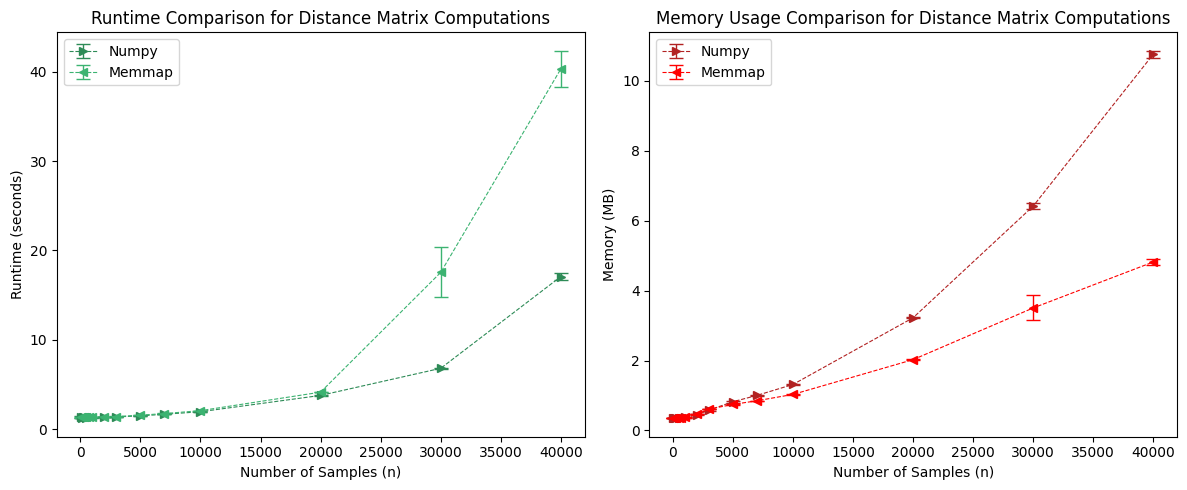

In [2]:
file_runtime = "./results_distancematrix/profiling_runtime.csv"
file_memory = "./results_distancematrix/profiling_memory.csv"
plot_benchmark_distance_matrix(file_runtime, file_memory)

### Benchmark Summary

**Runtime:** NumPy is consistently faster than Memmap, especially for larger datasets.  
**Memory Usage:** Memmap uses significantly less memory than NumPy, making it more suitable for large-scale data.

**Overall Insight:**
NumPy is ideal when speed is critical and sufficient RAM is available. Memmap trades speed for memory efficiency, enabling distance matrix computation for datasets that exceed main memory limits. The choice depends on whether runtime or memory usage is the primary constraint in the clustering workflow.

## Clustering Algorithms

We aim to improve the performance of the k-medoids clustering used in FGC, enabling interpretability at scale for large datasets. Our current implementation leverages the `kmedoids` Python library to perform k-medoids clustering using one of the following methods:

* **`pam`**: The original Partitioning Around Medoids algorithm, introduced by Kaufman & Rousseeuw (1990).
* **`fastpam1`**: An optimized version of PAM proposed by Schubert & Rousseeuw (2019), which computes the same swaps as the original PAM but finds the optimal swap **O(k)** times faster.
* **`fasterpam`**: A further improvement by Schubert & Rousseeuw (2021), which eagerly applies any beneficial swap it finds, while retaining the **O(k)** speedup for identifying the best swaps.

For a detailed comparison of these algorithms, refer to [Schubert & Rousseeuw (2021)](https://doi.org/10.1016/j.is.2021.101804).

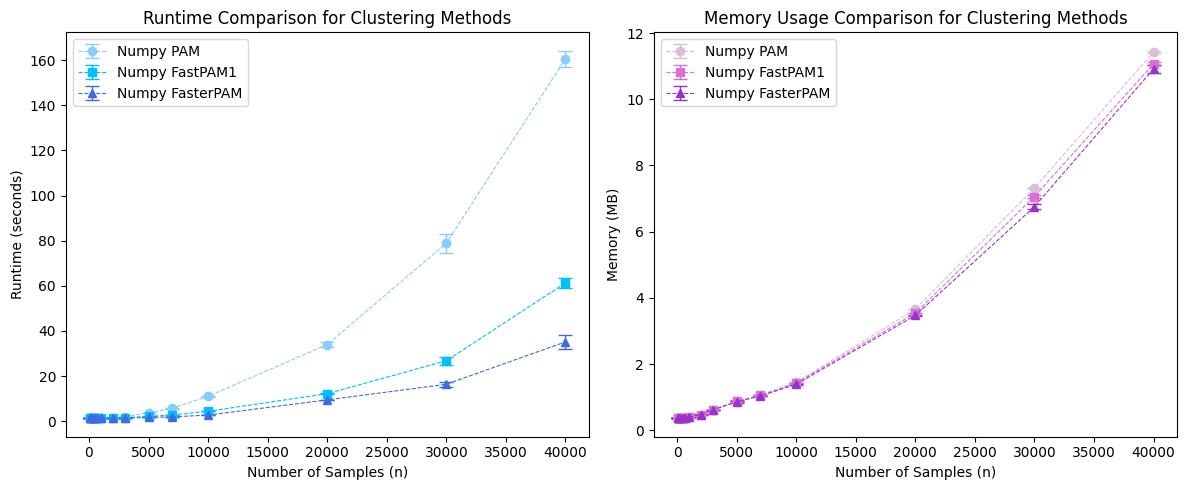

In [3]:
file_runtime = "./results_cluster_methods/profiling_runtime.csv"
file_memory = "./results_cluster_methods/profiling_memory.csv"
plot_benchmark_cluster_methods(file_runtime, file_memory)

### Benchmark Summary

**Runtime:** FasterPAM is the fastest clustering method, followed by FastPAM1, with the original PAM being the slowest—showing significant runtime differences as sample size increases.

**Memory Usage:** All three methods (PAM, FastPAM1, FasterPAM) exhibit similar memory usage, growing quadratically with sample size, with only minimal differences between them.

**Overall Insight:**
Optimized variants of the PAM algorithm (FastPAM1 and FasterPAM) offer substantial runtime improvements, making them far more scalable for large datasets. Despite these speed gains, memory usage remains nearly identical across all methods. 

## K-Medoids for Large Datasets

Clustering with K-Medoids on large datasets is computationally expensive due to the need for full pairwise distance calculations. The standard K-Medoids algorithm evaluates all possible swaps between medoids and non-medoids, resulting in a time complexity of **O(n²k)**. This makes it impractical for very large datasets, especially those with millions of data points.

Several algorithmic variants of K-Medoids have been proposed to reduce this computational burden, including **PAM** (Partitioning Around Medoids), **CLARA** (Clustering Large Applications), and **CLARANS** (Clustering Large Applications based on Randomized Search).

Since we are already using a PAM-based implementation (specifically FasterPAM), we next explore **CLARA** and **CLARANS** as strategies to scale K-Medoids to larger datasets.

For an overview of these methods, see: [Optimizing K-Medoids for Large Datasets](https://aicompetence.org/optimizing-k-medoids-for-large-datasets/)


### CLARA (Clustering Large Applications)

* **Paper:** [Ng & Han, 1994](https://cs.ecu.edu/dingq/CSCI6905/readings/CLARANS.pdf)
* **Reference Code:** [scikit-learn-extra CLARA implementation](https://scikit-learn-extra.readthedocs.io/en/stable/_modules/sklearn_extra/cluster/_k_medoids.html#CLARA)

**Algorithm Overview:**

For `n_sampling_iter` iterations:

1. Draw a random subset of the dataset.

   * Sample size is computed as:
     `n_sampling = max(min(n, 40 + 2 * n_clusters), n_clusters + 1)`
2. Compute the distance matrix for the sampled subset using our optimized `memmap + numba` approach.
3. Run K-Medoids (FasterPAM) on the sampled data.
4. Assign each point in the full dataset to the nearest medoid found in Step 3.
5. Compute the **average dissimilarity (inertia)**. If this is lower than previously observed values, retain this as the best clustering.

> **Note**: The sklearn-extra package is unmaintained and incompatible with NumPy >= 2.0. We therefore reimplemented CLARA’s core logic, plugging in our optimized distance computation, inertia calculation, and label assignment.

### CLARANS (Clustering Large Applications via Randomized Search)

CLARANS extends PAM and CLARA by introducing **randomized local search** to escape local optima. Instead of exhaustively checking all swaps (as in PAM) or limiting sampling to a fixed subset (as in CLARA), CLARANS randomly samples a fixed number of neighbor configurations across the entire dataset. This broader sampling strategy reduces the likelihood of getting stuck in poor local minima.

* **Paper:** [Raymond et al., 2002](http://www.cs.ecu.edu/dingq/CSCI6905/readings/CLARANS.pdf)
* **Further Reading:** [CLARANS explained with Python example](https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4)

Although CLARANS is implemented in the `pyclustering` library, it has two key limitations:

1. The library is no longer actively developed or maintained.
2. It does **not support custom distance matrices**, which is essential for our use case.

To overcome this, we adapted the core implementation of CLARANS from `pyclustering` to work with precomputed, custom distance matrices.

> **Note**, despite its theoretical advantages, our benchmarking showed that CLARANS **significantly increases runtime** without offering practical performance benefits. Therefore, we **disregard CLARANS** as a viable option in our pipeline.


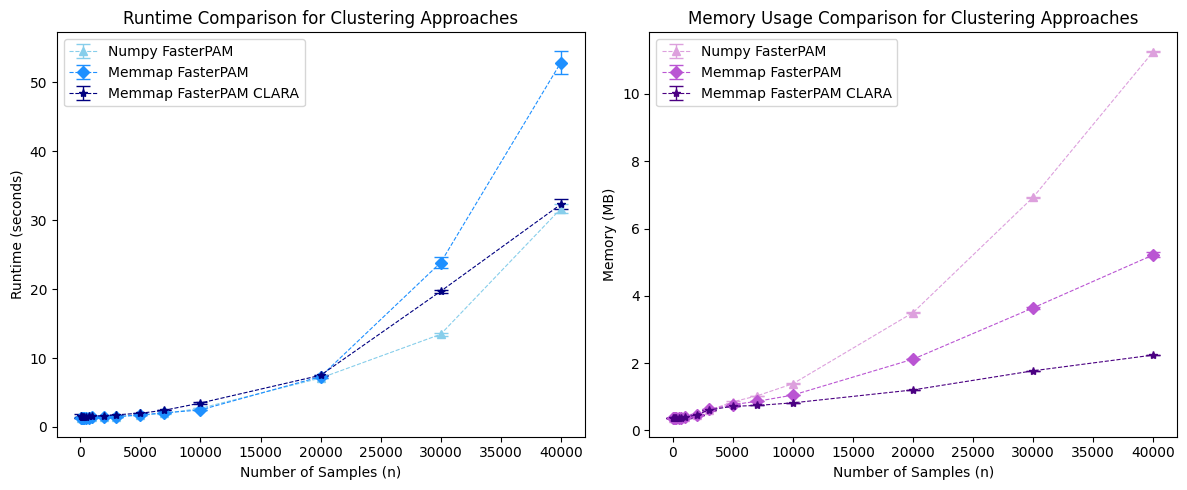

In [4]:
file_runtime = "./results_cluster_approaches/profiling_runtime.csv"
file_memory = "./results_cluster_approaches/profiling_memory.csv"
plot_benchmark_cluster_approaches(file_runtime, file_memory)

### Benchmark Summary

**Runtime:** NumPy FasterPAM is the fastest overall, followed by Memmap FasterPAM CLARA, while Memmap FasterPAM is the slowest due to disk I/O overhead.

**Memory Usage:** NumPy uses the most memory, Memmap reduces memory usage significantly, and Memmap FasterPAM CLARA has the lowest memory footprint across all sample sizes.

**Overall Insight:**
Memmap enables memory-efficient clustering on large datasets, while the CLARA variant provides a good balance between speed and memory savings. Although NumPy is fastest, it becomes impractical for large data due to high memory consumption. For large-scale clustering tasks, **Memmap FasterPAM with CLARA** is the most scalable and memory-efficient choice.